# 多目的最適化

最適化したい目的関数が複数 ($p$ 個) ある場合は、多目的最適化をおこないます。  
本チュートリアルでは、「解」は目的関数の組 $y = (y_1(x), y_2(x), \dots, y_p(x))$ を意味することに注意してください。  
解の大小関係 $\prec$ を以下のように定義します。  

$y \prec y^{'}\Longleftrightarrow \forall \ i \le p, y_i \le y^{'}_i  \land \exists \ j \le p, y_j < y^{'}_j$ 

（最大化問題における） **パレート解** とは、上記の大小関係の上で、自身よりも大きな解がないような解を指します。  
すなわち、任意の目的関数の値を改善しようとした場合、他の目的関数のうちどれかひとつは悪化するような解です。  
目的関数間にトレードオフが存在する場合は、パレート解は複数存在するため、それらを効率的に求めることが課題となります。

PHYSBOでは、パレート解を効率的に求めるためのベイズ最適化手法を実装しています。  

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import physbo
%matplotlib inline

Cythonized version of physbo is used


## テスト関数

本チュートリアルでは、多目的最適化のベンチマーク関数である VLMOP2 を利用します。  
目的関数の数は2つです。

$$
\begin{split}
    y_1(\vec{x}) &= 1 - \exp\left[-\sum_{i=1}^N\left( x_i - 1/\sqrt{N}\right)^2\right] \\
    y_2(\vec{x}) &= 1 - \exp\left[-\sum_{i=1}^N\left( x_i + 1/\sqrt{N}\right)^2\right]
\end{split}
$$

$y_1$ と $y_2$ はそれぞれ $x_1 = x_2 = \cdots x_N = 1/\sqrt{N}$ と $x_1 = x_2 = \cdots x_N = -1/\sqrt{N}$ に最小値があり、その値はともに０です。また、上界は1 です。

PHYSBO は最大化問題を仮定するため、-1を掛けたものをあらためて目的関数とします。

- 参考文献
    - Van Veldhuizen, David A. Multiobjective evolutionary algorithms: classifications, analyses, and new innovations. No. AFIT/DS/ENG/99-01. AIR FORCE INST OF TECH WRIGHT-PATTERSONAFB OH SCHOOL OF ENGINEERING, 1999.

In [2]:
def vlmop2_minus(x):
    n = x.shape[1]
    y1 = 1 - np.exp(-1 * np.sum((x - 1/np.sqrt(n)) ** 2, axis = 1))
    y2 = 1 - np.exp(-1 * np.sum((x + 1/np.sqrt(n)) ** 2, axis = 1))

    return np.c_[-y1, -y2]

## 探索候補データの準備

入力空間 $\vec{x}$ は 2次元とし、[-2, 2] × [-2, 2] の上で候補点をグリッド状に生成します。

In [3]:
import itertools
a = np.linspace(-2,2,101)
test_X = np.array(list(itertools.product(a, a)))

In [4]:
test_X

array([[-2.  , -2.  ],
       [-2.  , -1.96],
       [-2.  , -1.92],
       ...,
       [ 2.  ,  1.92],
       [ 2.  ,  1.96],
       [ 2.  ,  2.  ]])

In [5]:
test_X.shape

(10201, 2)

## simulator の定義

In [6]:
class Simulator(object):
    def __init__(self, X):
        self.t = vlmop2_minus(X)
    
    def __call__( self, action):
        return self.t[action]

In [7]:
simu = Simulator(test_X)

## 関数のプロット

2つの目的関数をそれぞれプロットしてみましょう。  
1つ目の目的関数は右上にピークがあり、2つ目の目的関数は左下にピークがあるようなトレードオフがある状態となっています。
（星はピークの位置です）

### 1つ目の目的関数

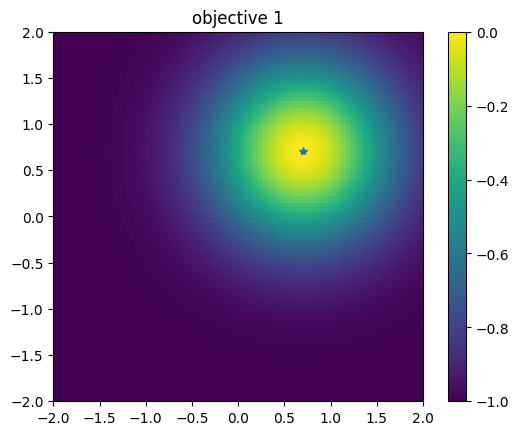

In [8]:
plt.figure()
plt.imshow(simu.t[:,0].reshape((101,101)), vmin=-1.0, vmax=0.0, origin="lower", extent=[-2.0, 2.0, -2.0, 2.0])
plt.title("objective 1")
plt.colorbar()
plt.plot([1.0/np.sqrt(2.0)], [1.0/np.sqrt(2.0)], '*')
plt.show()

### 2つ目の目的関数

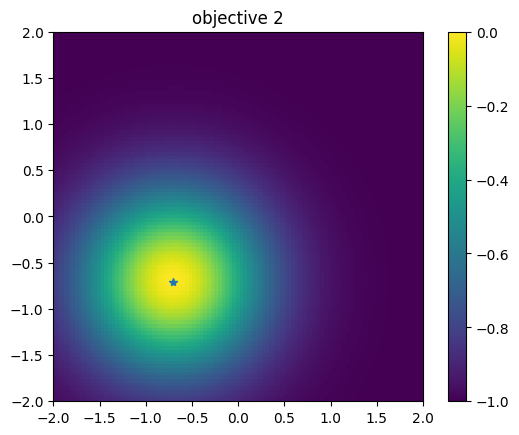

In [9]:
# plot objective 2
plt.figure()
plt.imshow(simu.t[:,1].reshape((101,101)), vmin=-1.0, vmax=0.0, origin="lower", extent=[-2.0, 2.0, -2.0, 2.0])
plt.title("objective 2")
plt.colorbar()
plt.plot([-1.0/np.sqrt(2.0)], [-1.0/np.sqrt(2.0)], '*')
plt.show()

## 最適化の実行

### Policy のセット

多目的最適化用の `physbo.search.discrete_multi.Policy` を利用します。  
`num_objectives` に目的関数の数を指定してください。

In [10]:
policy = physbo.search.discrete_multi.Policy(test_X=test_X, num_objectives=2)
policy.set_seed(0)

通常の `physbo.search.discrete.policy` (目的関数が1つの場合）と同じく、`random_search` または `bayes_search` メソッドを呼ぶことで最適化を行います。  
基本的なAPIや利用方法は `discrete.policy` とおおよそ共通しています。

### ランダムサーチ

In [11]:
policy = physbo.search.discrete_multi.Policy(test_X=test_X, num_objectives=2)
policy.set_seed(0)

res_random = policy.random_search(max_num_probes=50, simulator=simu)

0001-th step: f(x) = [-0.99973003 -0.62334035] (action = 836)
   Pareto set updated.
   the number of Pareto frontiers = 1 

0002-th step: f(x) = [-0.99789981 -0.99866427] (action = 9404)
   Pareto set updated.
   the number of Pareto frontiers = 2 

0003-th step: f(x) = [-0.99090897 -0.46609239] (action = 4664)
   Pareto set updated.
   the number of Pareto frontiers = 1 

0004-th step: f(x) = [-0.92633083 -0.29208351] (action = 4780)
   Pareto set updated.
   the number of Pareto frontiers = 1 

0005-th step: f(x) = [-0.67969326 -0.99981691] (action = 9566)
   Pareto set updated.
   the number of Pareto frontiers = 2 

0006-th step: f(x) = [-0.45601619 -0.99848443] (action = 8852)
   Pareto set updated.
   the number of Pareto frontiers = 2 

0007-th step: f(x) = [-0.92670204 -0.71508873] (action = 6088)
0008-th step: f(x) = [-0.58233995 -0.99952931] (action = 7060)
0009-th step: f(x) = [-0.99848229 -0.96780195] (action = 473)
0010-th step: f(x) = [-0.80479332 -0.99994946] (action = 

目的関数の評価値(の array) とそのときの action ID が表示されます。  
また、パレート解集合 (Pareto set) が更新されたときにメッセージを表示します。

Pareto set が更新された際に中身を表示したい場合は、`disp_pareto_set=True` と指定します。  
Pareto set は1つ目の目的関数値の昇順でソートされています。

In [12]:
policy = physbo.search.discrete_multi.Policy(test_X=test_X, num_objectives=2)
policy.set_seed(0)
res_random = policy.random_search(max_num_probes=50, simulator=simu, disp_pareto_set=True)

0001-th step: f(x) = [-0.99973003 -0.62334035] (action = 836)
   Pareto set updated.
   current Pareto set = [[-0.99973003 -0.62334035]] (steps = [1]) 

0002-th step: f(x) = [-0.99789981 -0.99866427] (action = 9404)
   Pareto set updated.
   current Pareto set = [[-0.99973003 -0.62334035]
 [-0.99789981 -0.99866427]] (steps = [1 2]) 

0003-th step: f(x) = [-0.99090897 -0.46609239] (action = 4664)
   Pareto set updated.
   current Pareto set = [[-0.99090897 -0.46609239]] (steps = [3]) 

0004-th step: f(x) = [-0.92633083 -0.29208351] (action = 4780)
   Pareto set updated.
   current Pareto set = [[-0.92633083 -0.29208351]] (steps = [4]) 

0005-th step: f(x) = [-0.67969326 -0.99981691] (action = 9566)
   Pareto set updated.
   current Pareto set = [[-0.92633083 -0.29208351]
 [-0.67969326 -0.99981691]] (steps = [4 5]) 

0006-th step: f(x) = [-0.45601619 -0.99848443] (action = 8852)
   Pareto set updated.
   current Pareto set = [[-0.92633083 -0.29208351]
 [-0.45601619 -0.99848443]] (steps =

### 結果の確認

 #### 評価値の履歴

In [ ]:
res_random.fx[0:res_random.num_runs]

#### パレート解の取得

In [14]:
front, front_num = res_random.export_pareto_front()
front, front_num

(array([[-0.95713719, -0.09067194],
        [-0.92633083, -0.29208351],
        [-0.63329589, -0.63329589],
        [-0.52191048, -0.72845916],
        [-0.26132949, -0.87913689],
        [-0.17190645, -0.91382463]]),
 array([40,  3, 19, 16, 29, 41]))

#### 解（評価値）のプロット

これ以降、図示する空間が $y = (y_1, y_2)$ であり $x = (x_1, x_2)$ ではないことにあらためて注意してください。

赤のプロットがパレート解です。

In [15]:
def plot_pareto_front(res):
    front, front_num = res.export_pareto_front()
    dominated = [i for i in range(res.num_runs) if i not in front_num]
    points = res.fx[dominated, :]

    plt.figure(figsize=(7, 7))
    plt.scatter(res.fx[dominated,0], res.fx[dominated,1], c = "blue")
    plt.scatter(front[:, 0], front[:, 1], c = "red")
    plt.title('Pareto front')
    plt.xlabel('Objective 1')
    plt.ylabel('Objective 2')
    plt.xlim([-1.0,0.0])
    plt.ylim([-1.0,0.0])

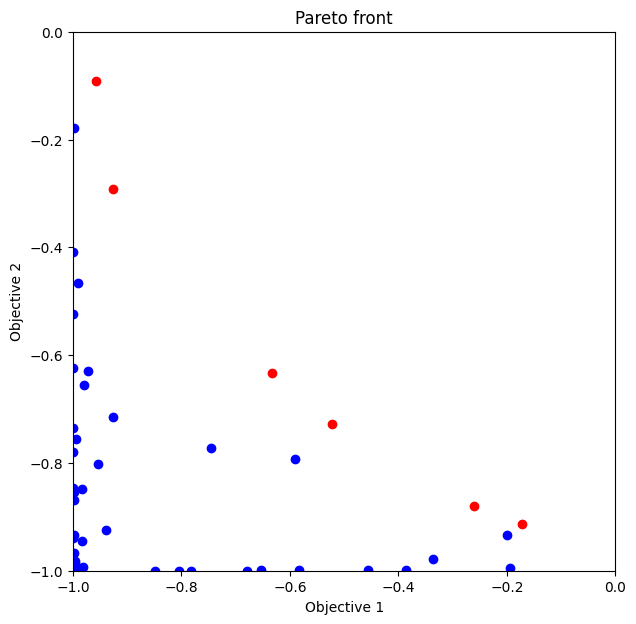

In [16]:
plot_pareto_front(res_random)

#### 劣解領域 (dominated region) の体積を計算

パレート解ではない解、すなわち、「自らよりも優れた解 $y'$ が存在する解 $y$ 」 を劣解と呼びます ($\exists y' y \prec y'$)。  
解空間（の部分空間）のうち、劣解の占める空間である劣解領域の体積は、多目的最適化の結果を示す指標のひとつです。  
この値が大きいほど、より良いパレート解が多く求まっていることになります。

`res_random.pareto.volume_in_dominance(ref_min, ref_max)` は、
`ref_min`, `ref_max` で指定された矩形(hyper-rectangle) 中の劣解領域体積を計算します。

In [17]:
res_random.pareto.volume_in_dominance([-1,-1],[0,0])

0.2376881844865093

## ベイズ最適化

多目的の場合の `bayes_search` では、`score` には以下のいずれかを指定します。

- HVPI (HyperVolume-based Probability of Improvement)
- EHVI (Expected Hyper-Volume Improvement)
- TS (Thompson Sampling)

以下、score を変えてそれぞれ 50回 (ランダムサーチ10回 + ベイズ最適化 40回) 評価を行います。

### HVPI (HyperVolume-based Probability of Improvement)

多次元の目的関数空間における非劣解領域 (non-dominated region) の改善確率を score として求めます。  

- 参考文献
    - Couckuyt, Ivo, Dirk Deschrijver, and Tom Dhaene. "Fast calculation of multiobjective probability of improvement and expected improvement criteria for Pareto optimization." Journal of Global Optimization 60.3 (2014): 575-594.

In [ ]:
policy = physbo.search.discrete_multi.Policy(test_X=test_X, num_objectives=2)
policy.set_seed(0)

policy.random_search(max_num_probes=10, simulator=simu)
res_HVPI = policy.bayes_search(max_num_probes=40, simulator=simu, score='HVPI', interval=10)

#### パレート解のプロット

ランダムサンプリングと比較して、パレート解が多く求まっていることが分かります。

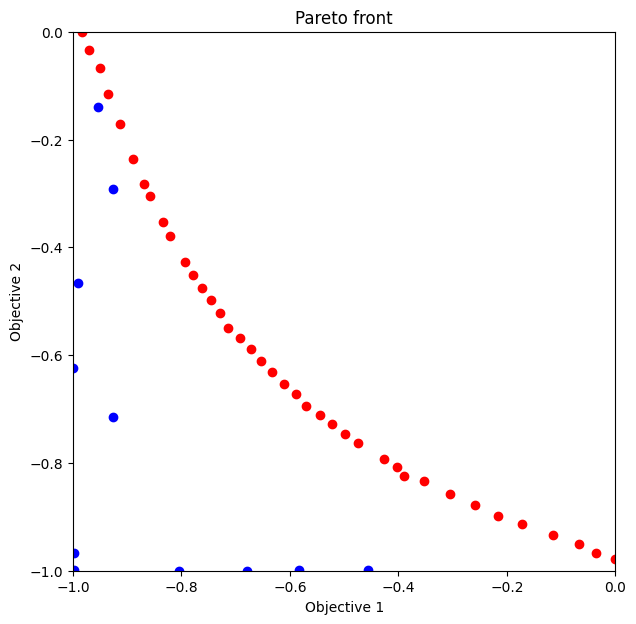

In [19]:
plot_pareto_front(res_HVPI)

#### 劣解領域体積

In [20]:
res_HVPI.pareto.volume_in_dominance([-1,-1],[0,0])

0.32877907991633726

### EHVI (Expected Hyper-Volume Improvement)

多次元の目的関数空間における非劣解領域 (non-dominated region) の改善期待値を score として求めます。  

- 参考文献
    - Couckuyt, Ivo, Dirk Deschrijver, and Tom Dhaene. "Fast calculation of multiobjective probability of improvement and expected improvement criteria for Pareto optimization." Journal of Global Optimization 60.3 (2014): 575-594.

In [ ]:
policy = physbo.search.discrete_multi.Policy(test_X=test_X, num_objectives=2)
policy.set_seed(0)

policy.random_search(max_num_probes=10, simulator=simu)
res_EHVI = policy.bayes_search(max_num_probes=40, simulator=simu, score='EHVI', interval=10)

#### パレート解のプロット

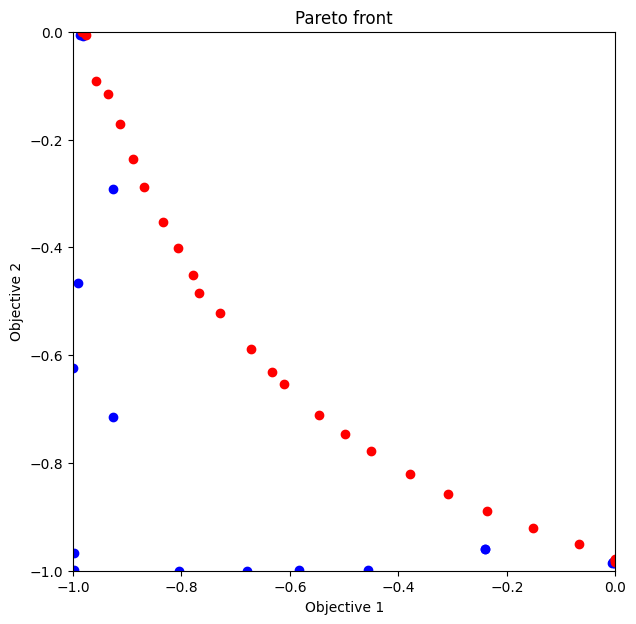

In [22]:
plot_pareto_front(res_EHVI)

#### 劣解領域体積

In [23]:
res_EHVI.pareto.volume_in_dominance([-1,-1],[0,0])

0.3200467412741881

### TS (Thompson Sampling)

単目的の場合の Thompson Sampling では、各候補(test_X)について、目的関数の事後分布からサンプリングを行い、値が最大となる候補を次の探索点として推薦します。  
多目的の場合は、サンプリングした値についてパレートルールの上で最大となる候補、つまりパレート最適な候補の中からランダムに1つ選択して次の探索点とします。

- 参考文献
    - Yahyaa, Saba Q., and Bernard Manderick. "Thompson sampling for multi-objective multi-armed bandits problem." Proc. Eur. Symp. Artif. Neural Netw., Comput. Intell. Mach. Learn.. 2015.

In [ ]:
policy = physbo.search.discrete_multi.Policy(test_X=test_X, num_objectives=2)
policy.set_seed(0)

policy.random_search(max_num_probes=10, simulator=simu)
res_TS = policy.bayes_search(max_num_probes=40, simulator=simu, score='TS', interval=10, num_rand_basis=5000)

#### パレート解のプロット

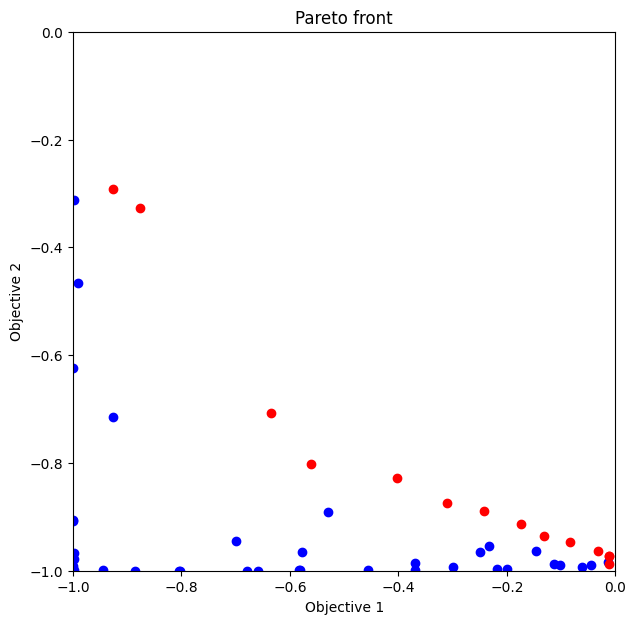

In [25]:
plot_pareto_front(res_TS)

#### 劣解領域体積

In [26]:
res_TS.pareto.volume_in_dominance([-1,-1],[0,0])

0.23103794208330097

## 付録：全探索

`random_search` で `max_num_probes` に全データ数 (`N = test_X.shape[0]`) を渡すと手軽に全探索できます。  
全データの評価には時間がかかるため、あらかじめデータ数を減らしておきます。

In [ ]:
test_X_sparse = np.array(list(itertools.product(np.linspace(-2, 2, 21), repeat=2)))
simu_sparse = Simulator(test_X_sparse)

policy = physbo.search.discrete_multi.Policy(test_X=test_X_sparse, num_objectives=2)
policy.set_seed(0)

N = test_X_sparse.shape[0]
res_all = policy.random_search(max_num_probes=N, simulator=simu_sparse)

#### パレート解のプロット

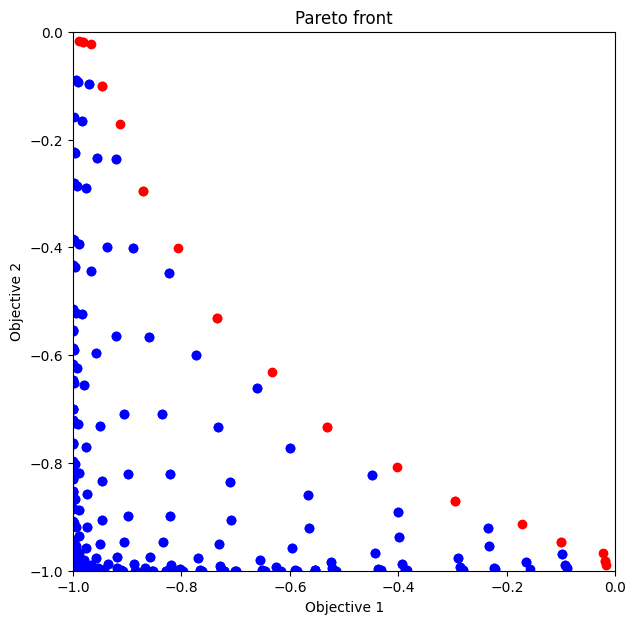

In [28]:
plot_pareto_front(res_all)

#### 劣解領域体積

In [29]:
res_all.pareto.volume_in_dominance([-1,-1],[0,0])

0.30051687493437484